# Problem Set 2

## Experiments and Causality

Romulo Manzano

# 1.  FE exercise 3.6
The Clingingsmith, Khwaja, and Kremer study discussed in section 3.5 may be be used to test the sharp null hypothesis that winning the visa lottery for the pilgrimage to Mecca had no effect on the views of Pakistani Muslims toward people from other countries. Assume that the Pakistani authorities assigned visas using complete random assignment. 

In [95]:
d3.6 <- read.csv("./data/Clingingsmith.2009.csv")
head(d3.6)

success,views_saudi,views_indonesian,views_turkish,views_african,views_chinese,views_european,views
0,1,1,0,0,0,0,2
0,1,1,0,-1,1,-1,1
0,0,0,0,0,0,0,0
0,2,2,0,0,1,0,5
0,1,1,1,1,1,-2,3
0,2,0,0,0,0,0,2


a. Conduct 10,000 simulated random assignments under the sharp null hypothesis. (Don't just copy the code from the async, think about how to write this yourself.) 

**Answer**

Function to generate random assignment of the rows:

In [126]:
set.seed(23)
randomize <- function() sample(c(0,1), nrow(d3.6), replace = TRUE)

We then proceed to define a function that derives the ATE

In [129]:
ate <- function(dataset)
    { return (mean(dataset[dataset$success==1,]$views) 
              - mean(dataset[dataset$success==0,]$views))
     }

Corroborating that the above function does result on the same ATE highlighted on the book (0.47)

In [130]:
originalATE <- ate(d3.6)

In [131]:
randomSimulationATE = function(x) {
    trialX <- cbind(x)
    trialX$success <- randomize()
    effect <- ate(trialX)
  return(effect)
}

In [132]:
simulations <- c()
for (i in seq(1,10000))
    {
    simulations[i] <- randomSimulationATE(d3.6)
    }

b. How many of the simulated random assignments generate an estimated ATE that is at least as large as the actual estimate of the ATE? 

**Answer**

In [133]:
sum(simulations >= originalATE)

[1] 20

c. What is the implied one-tailed p-value? 

**Answer**

In [139]:
mean(simulations > originalATE)

[1] 0.002

Let's also observe the distribution of the results obtained

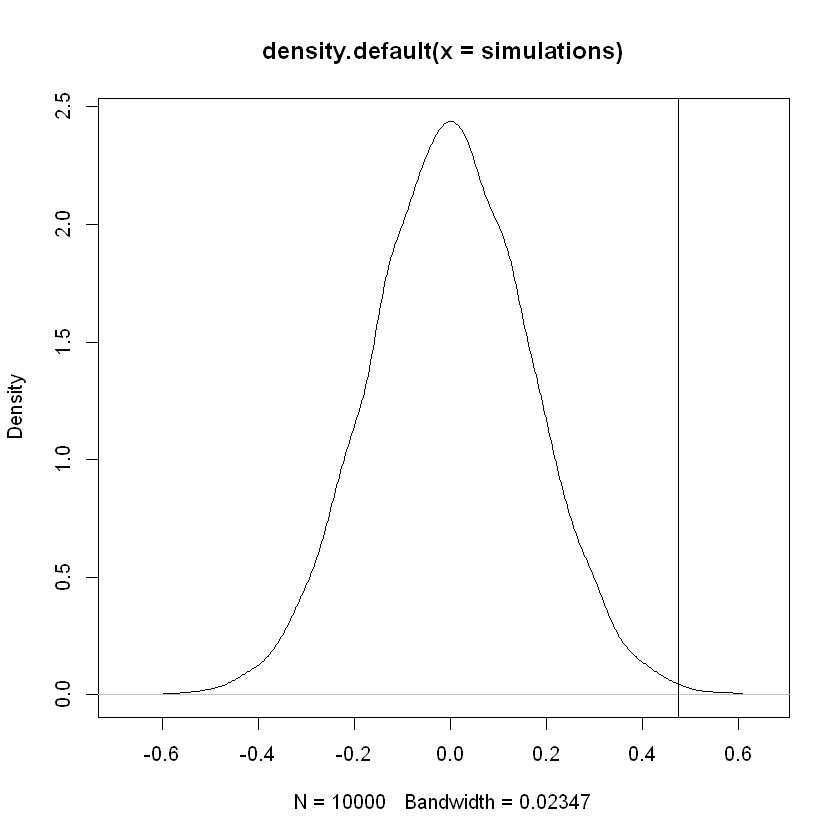

In [137]:
plot(density(simulations))
abline(v=originalATE)

d. How many of the simulated random assignments generate an estimated ATE that is at least as large *in absolute value* as the actual estimate of the ATE?

**Answer**

In [136]:
sum(lapply(simulations,abs) >= abs(originalATE))

[1] 38

e. What is the implied two-tailed p-value? 

**Answer**

In [140]:
mean(lapply(simulations,abs) > abs(originalATE))

[1] 0.0038

# 2.FE exercise 3.8
Naturally occurring experiments sometimes involve what is, in effect, block random assignment. For example, Titiunik studies the effect of lotteries that determine whether state senators in TX and AR serve two-year or four-year terms in the aftermath of decennial redistricting. These lotteries are conducted within each state, and so there are effectively two distinct experiments on the effects of term length. An interesting outcome variable is the number of bills (legislative proposals) that each senator introduces during a legislative session. The table below lists the number of bills introduced by senators in both states during 2003. 

If you're interested, or would like more clarification, the published version of the paper is in the repository. 


In [3]:
library(foreign)
d3.8 <- read.dta("./data/Titiunik.2010.dta")
head(d3.8)

term2year,bills_introduced,texas0_arkansas1
0,18,0
0,29,0
0,41,0
0,53,0
0,60,0
0,67,0


a. For each state, estimate the effect of having a two-year term on the number of bills introduced. 

**Answer**

First we define a function to calculate the differences in means for both treatment groups (term2year == 1 and term2year ==0 )

In [9]:
atePs2 <- function(dataset)
    { return (mean(dataset[dataset$term2year==1,]$bills_introduced) 
              - mean(dataset[dataset$term2year==0,]$bills_introduced))
     }

**Texas** average treatment effect

In [17]:
texas <- d3.8[d3.8$texas0_arkansas1==0,]
ateTX <- atePs2(texas)
ateTX

[1] -16.74167

**Arkansas** average treatment effect

In [18]:
arkansas <- d3.8[d3.8$texas0_arkansas1==1,]
ateAK <- atePs2(arkansas)
ateAK

[1] -10.09477

b. For each state, estimate the standard error of the estimated ATE. 

**Answer**

Let's start by defining a function to determine the standard error of the mean

In [28]:
stdErrorATEPs2 <- function(dataset)
    { 
    m <- nrow(dataset[dataset$term2year==1,])
    N <- nrow(dataset)
    var_y0 <- var(dataset[dataset$term2year==0,]$bills_introduced)
    var_y1 <- var(dataset[dataset$term2year==1,]$bills_introduced)
    se <- sqrt((var_y0/(N-m)) + (var_y1/m))
    return (se)
    }

**Texas**

In [30]:
stdErrorATEPs2(texas)

[1] 9.345871

**Arkansas**

In [31]:
stdErrorATEPs2(arkansas)

[1] 3.395979

c. Use equation (3.10) to estimate the overall ATE for both states combined. 

**Answer**

In [35]:
ateAcrossBlocks <- function(dataset)
    {
        N <- nrow(dataset)
        arkansas <- dataset[dataset$texas0_arkansas1==1,]
        arkansasN <- nrow(arkansas)
        arkansasATE <- atePs2(arkansas)
        texas <- dataset[dataset$texas0_arkansas1==0,]
        texasN <- nrow(texas) 
        texasATE <- atePs2(texas)
        return(((arkansasN/N)*arkansasATE)+((texasN/N)*texasATE))
    }

In [36]:
ateAcrossBlocks(d3.8)

[1] -13.2168

d. Explain why, in this study, simply pooling the data for the two states and comparing the average number of bills introduced by two-year senators to the average number of bills introduced by four-year senators leads to biased estimate of the overall ATE. 

**Answer**

Pooling across these two different states might indeed lead to biased estimates of the overall ATE for a couple of reasons. Primarily because the lottery process used to determine which senators will have a 2 vs a 4 year term could be inherintly different for each state - for example, existence of a placebo period during which senators begin their terms without precisely knowing whether it'd be 2 or 4 years log . Similarly, the expected number of bills introduced for any one state might be dependent on unique characteristics of the states themselves or even changes on the political agenda of the party dominating the state senate. These factors will render the populations within each state far from similar.

e. Insert the estimated standard errors into equation (3.12) to estimate the stand error for the overall ATE. 

**Answer**

In [40]:
seAcrossBlocks <- function(dataset)
    {
        N <- nrow(dataset)
        arkansas <- dataset[dataset$texas0_arkansas1==1,]
        arkansasN <- nrow(arkansas)
        arkansasSE <- stdErrorATEPs2(arkansas)
        texas <- dataset[dataset$texas0_arkansas1==0,]
        texasN <- nrow(texas) 
        texasSE <- stdErrorATEPs2(texas)
        return (sqrt((((arkansasN/N)^2) * (arkansasSE^2))+(((texasN/N)^2)*(texasSE^2))))
    }

In [41]:
seAcrossBlocks(d3.8)

[1] 4.74478

f. Use randomization inference to test the sharp null hypothesis that the treatment effect is zero for senators in both states.

In [42]:
randomizePS2 <- function(size) sample(c(0,1), size, replace = TRUE)

In [43]:
randomSimulationATEPS2 = function(dataset) {
    trialX <- cbind(dataset)
    trialX$term2year <- randomizePS2(nrow(dataset))
    effect <- atePs2(trialX)
  return(effect)
}

**Texas**

Since there is no explicit assumption on the directionality of the alternative hypothesis (term lenght does have an effect) we'll run a set of 10 thousand simulations and infer the p-value under a two tailed test at the 95% confidence level.

In [60]:
simulationsTexas <- c()
for (i in seq(1,10000))
    {
    simulationsTexas[i] <- randomSimulationATEPS2(texas)
    }

Two tailed p-value

In [65]:
mean(lapply(simulationsTexas,abs) > abs(ateTX))

[1] 0.0928

This means that we can't succesfully reject the null hypothesis at a 95% confidence level. In other words, the observed average effect for the realized randomization is within two standard deviations of the distribution generated via randomized inference, and it is likely the observed effect is the result of chance.

**Arkansas**

In [69]:
simulationsArkansas <- c()
for (i in seq(1,10000))
    {
    simulationsArkansas[i] <- randomSimulationATEPS2(arkansas)
    }

Two tailed p-value

In [71]:
mean(lapply(simulationsArkansas,abs) > abs(ateAK))

[1] 0.0052

Unlike the case of TX, this means that we can succesfully reject the null hypothesis at a 95% confidence level. In other words, the observed average effect for the realized randomization is beyond two standard deviations of the distribution generated via randomized inference, and it is unlikely the observed effect is the result of chance.

g. **In Addition:** Plot histograms for both the treatment and control groups in each state (for 4 histograms in total).

**Arkansas** treatment group (2yrs)

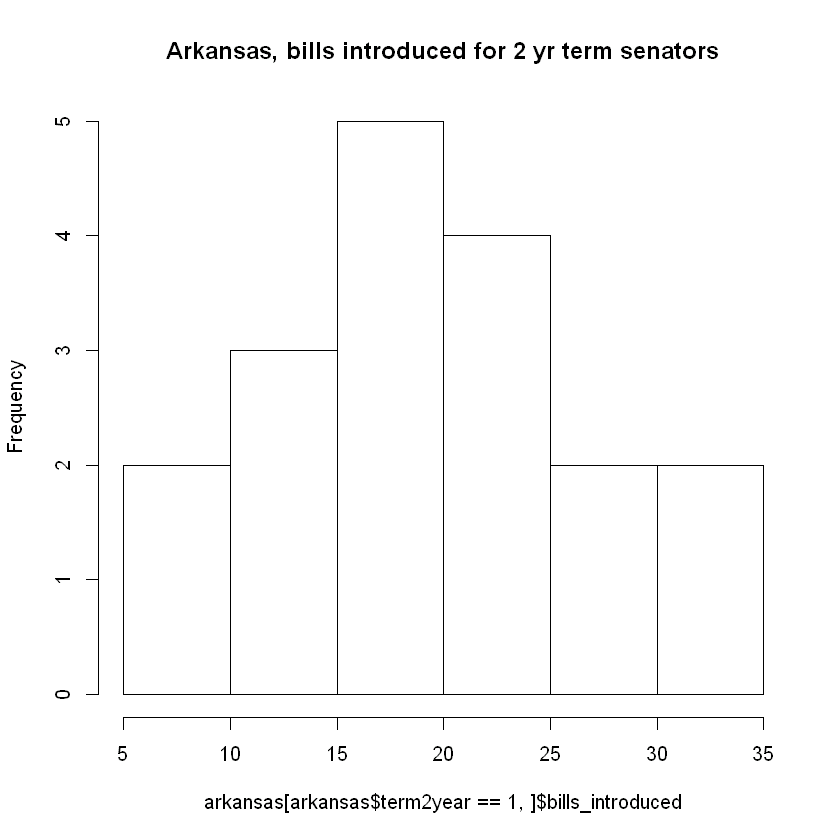

In [78]:
hist(arkansas[arkansas$term2year==1,]$bills_introduced,
     main = 'Arkansas, bills introduced for 2 yr term senators')

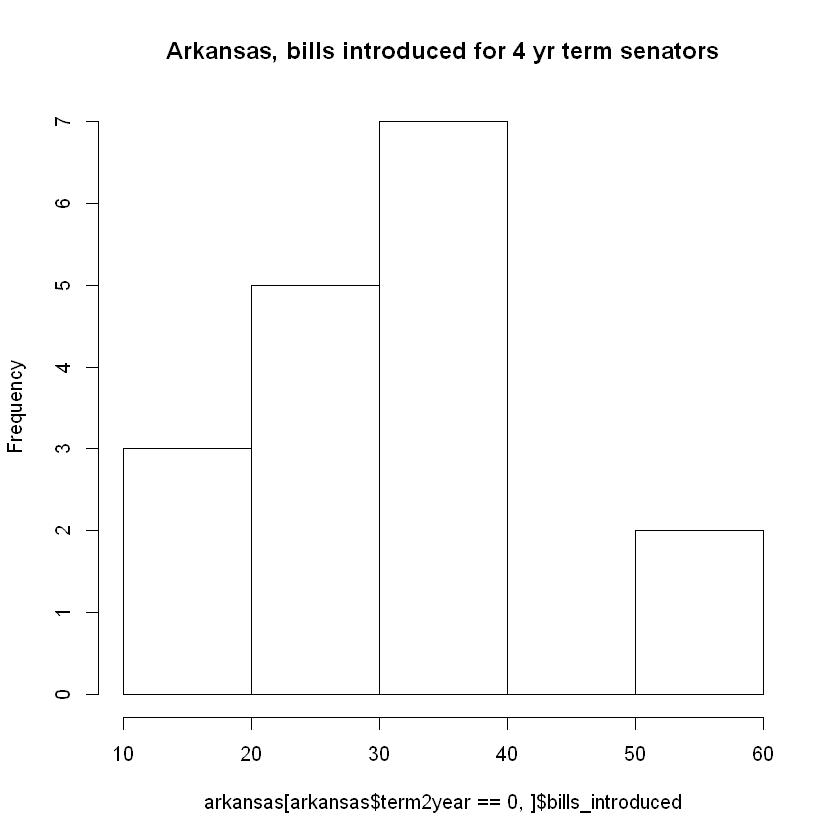

In [79]:
hist(arkansas[arkansas$term2year==0,]$bills_introduced,
     main = 'Arkansas, bills introduced for 4 yr term senators')

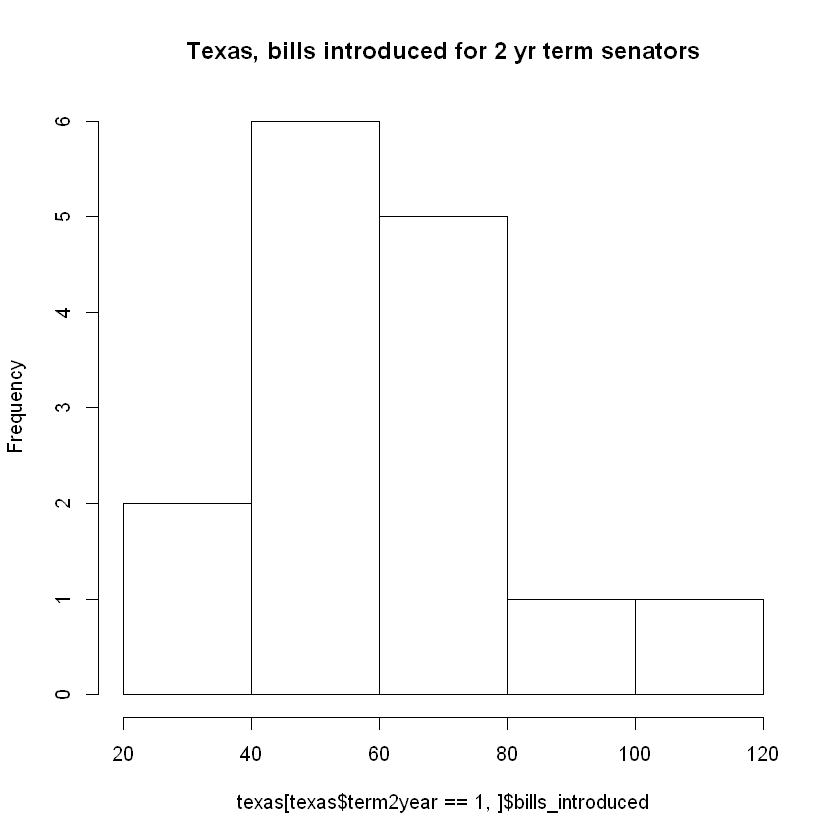

In [206]:
hist(texas[texas$term2year==1,]$bills_introduced,
     main = 'Texas, bills introduced for 2 yr term senators')

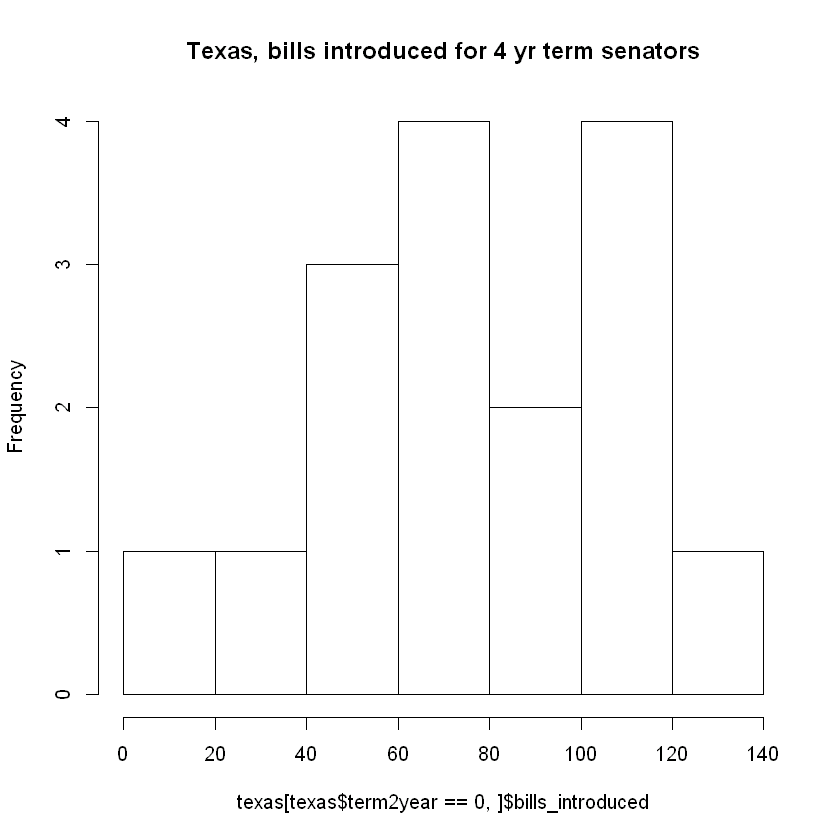

In [82]:
hist(texas[texas$term2year==0,]$bills_introduced,
     main = 'Texas, bills introduced for 4 yr term senators')

# 3. FE exercise 3.11
Use the data in table 3.3 to simulate cluster randomized assignment. <br>

(*Notes: (a) Assume 3 clusters in treatment and 4 in control; and (b) When Gerber and Green say ``simulate'', they do not mean ``run simulations with R code'', but rather, in a casual sense ``take a look at what happens if you do this this way.'' There is no randomization inference necessary to complete this problem.*)

In [85]:
d <- read.csv("./data/ggChapter3.csv")
d

Village,Y,D,Block
1,0,0,1
2,1,0,1
3,2,1,1
4,4,2,1
5,4,0,1
6,6,0,1
7,6,2,1
8,9,3,1
9,14,12,2
10,15,9,2


a. Suppose the clusters are formed by grouping observations {1,2}, {3,4}, {5,6}, ... , {13,14}. Use equation (3.22) to calculate the standard error assuming half of the clusters are randomly assigned to treatment. 

**Answer**

**Assigning clusters and treatment groups**

In [107]:
randomClusterTreatment <- function(clusters,clusterSize)
    {
    return(rep(randomizePS2(clusters),each=clusterSize))
}
    

In [109]:
dClusteredA <- cbind(d)
dClusteredA$cluster <- c(1,1,2,2,3,3,4,4,5,5,6,6,7,7)
dClusteredA$treatment <- randomClusterTreatment(7,2)
dClusteredA

Village,Y,D,Block,cluster,treatment
1,0,0,1,1,0
2,1,0,1,1,0
3,2,1,1,2,1
4,4,2,1,2,1
5,4,0,1,3,1
6,6,0,1,3,1
7,6,2,1,4,0
8,9,3,1,4,0
9,14,12,2,5,1
10,15,9,2,5,1


In [95]:
deriveClusterY0 <- function(dataset,cluster)
    {
        clusterSet <- cbind(dataset[dataset$cluster == cluster,])
        return(mean(clusterSet$Y))
    }
deriveClusterY1 <- function(dataset,cluster)
    {
        clusterSet <- cbind(dataset[dataset$cluster == cluster,])
        return(mean(clusterSet$D))
    }

In [114]:
standardErrorCluster <- function(dataset,numClusters)
    {
    
    vector_y0 <- c()
    vector_y1 <- c()
    for (i in seq(1,numClusters))
        {
        vector_y0[i] <- deriveClusterY0(dataset,i)
        vector_y1[i] <- deriveClusterY1(dataset,i)
        
        }
    n <- nrow(dataset)
    m <- nrow(dataset[dataset$treatment == 1,])
    var_y0 <- var(vector_y0)
    var_y1 <- var(vector_y1)
    cov_y <- cov(vector_y0,vector_y1)
    k <- numClusters
    
    se <- sqrt((1/(k-1))*(((m*var_y0)/(n-m))+(((n-m)*var_y1)/m)+(2*cov_y)))
    return(se)
    }

In [115]:
standardErrorCluster(dClusteredA,7)

[1] 4.918953

b. Suppose that clusters are instead formed by grouping observations {1,14}, {2,13}, {3,12}, ... , {7,8}. Use equation (3.22) to calculate the standard error assuming half of the clusters are randomly assigned to treatment. 

**Answer**

In [113]:
dClusteredB <- cbind(d)
dClusteredB$cluster <- c(1,2,3,4,5,6,7,7,6,5,4,3,2,1)
dClusteredB$treatment <- randomClusterTreatment(7,2)
dClusteredB

Village,Y,D,Block,cluster,treatment
1,0,0,1,1,0
2,1,0,1,2,0
3,2,1,1,3,1
4,4,2,1,4,1
5,4,0,1,5,1
6,6,0,1,6,1
7,6,2,1,7,1
8,9,3,1,7,1
9,14,12,2,6,1
10,15,9,2,5,1


In [116]:
standardErrorCluster(dClusteredB,7)

[1] 0.9587732

c. Why do the two methods of forming clusters lead to different standard errors? What are the implications for the design of cluster randomized experiments? 

**Answer** If you take a closer look at the data it seems to be sorted by Y_0, which means that forming clusters based on the sequence on which they appear on the dataset will pair subjects with lower Y0 together, as well as subjects with larger Y1. This in effects results in clusters that are on average very dissimilar from each other.

In contrast, when creating clusters based on approach B, we are pairing lowest with highest creating clusters that on average have very similar Y0 (despite most clusters containing very dissimilar subjects). As a result, the standard error is smaller with the second approach as the treatment effects are on average closer than on the first assignment.

# 4. More Practice #1
You are an employee of a newspaper and are planning an experiment to demonstrate to Apple that online advertising on your website causes people to buy iPhones. Each site visitor shown the ad campaign is exposed to $0.10 worth of advertising for iPhones. (Assume all users could see ads.) There are 1,000,000 users available to be shown ads on your newspaperâs website during the one week campaign. 

Apple indicates that they make a profit of $100 every time an iPhone sells and that 0.5% of visitors to your newspaperâs website buy an iPhone in a given week in general, in the absence of any advertising.

a. By how much does the ad campaign need to increase the probability of purchase in order to be âworth itâ and a positive ROI (supposing there are no long-run effects and all the effects are measured within that week)?

**Answer**

Assuming each user shown the add during the campaign will result in a 0.10 charge, the total cost of showing the add on all users will be 10,000 dollars. That means that for the campaign to have a possitive ROI it should generate at least 10,000 dollars of additional profit for Apple, which means at least an additional 100 iPhones should be sold.

That means the number of visitors that buy an iPhone should increase from 50 thousand (currently 0.05% of users buy) to 50,100 to break even, that means the probability of users buying an iPhone on the website should increase from 0.05% to 0.0501% for the campaign to be worthwhile

b. Assume the measured effect is 0.2 percentage points. If users are split 50:50 between the treatment group (exposed to iPhone ads) and control group (exposed to unrelated advertising or nothing; something you can assume has no effect), what will be the confidence interval of your estimate on whether people purchase the phone?

  + **Note:** The standard error for a two-sample proportion test is $\sqrt{p(1-p)*(\frac{1}{n_{1}}+\frac{1}{n_{2}})}$ where $p=\frac{x_{1}+x_{2}}{n_{1}+n_{2}}$, where $x$ and $n$ refer to the number of âsuccessesâ (here, purchases) over the number of âtrialsâ (here, site visits). The length of each tail of a 95% confidence interval is calculated by multiplying the standard error by 1.96.

In [148]:
stdErrorQ4b <- function()
    {
    p <- (((0.005*500000) + (0.007*500000))/(500000+500000))
    n_1_over_n <- (1/500000)
    return (sqrt(p*(1-p)*(n_1_over_n+n_1_over_n)))
}

In [149]:
1.96*stdErrorQ4b()

[1] 0.0003027296

**Answer**

95% confidence interval of the estimate is +/- 0.03 (percentage points). i.e. (0.17,0.23)

c. Is this confidence interval precise enough that you would recommend running this experiment? Why or why not?

**Answer**

This confidence interval is precise enough that I would recommend running the experiment given that the lower bound of the confidence interval is way higher than the minimum required probability increase to break even (0.001 percentage points) 

d. Your boss at the newspaper, worried about potential loss of revenue, says he is not willing to hold back a control group any larger than 1% of users. What would be the width of the confidence interval for this experiment if only 1% of users were placed in the control group?


In [161]:
stdErrorQ4d <- function()
    {
    p <- (((0.005*10000) + (0.007*990000))/(1000000))
    n_1_over_n_control <- (1/10000)
    n_1_over_n_treat <- (1/990000)
    return (sqrt(p*(1-p)*(n_1_over_n_control+n_1_over_n_treat)))
}

In [162]:
1.96*stdErrorQ4d()

[1] 0.001640005

95% confidence interval if only 1% of the users are held for control would be +/- 0.16 (percentage points). i.e. (0.04,0.36)

# 5. More Practice #2
Here you will find a set of data from an auction experiment by John List and David Lucking-Reiley ([2000](https://drive.google.com/file/d/0BxwM1dZBYvxBNThsWmFsY1AyNEE/view?usp=sharing)).  

In [166]:
d2 <- read.csv("./data/listData.csv")
head(d2)

bid,uniform_price_auction
5,1
5,1
20,0
0,1
20,1
0,1


In this experiment, the experimenters invited consumers at a sports card trading show to bid against one other bidder for a pair trading cards.  We abstract from the multi-unit-auction details here, and simply state that the treatment auction format was theoretically predicted to produce lower bids than the control auction format.  We provide you a relevant subset of data from the experiment.

a. Compute a 95% confidence interval for the difference between the treatment mean and the control mean, using analytic formulas for a two-sample t-test from your earlier statistics course. 

In [171]:
sErrorQ5a <- function(data)
    {
    y0 <- cbind(data[data$uniform_price_auction==0,]$bid)
    y1 <- cbind(data[data$uniform_price_auction==1,]$bid)
    return (sqrt((var(y0)/(nrow(y0))) + (var(y1)/(nrow(y1)))))
    }

In [178]:
sErrorQ5a(d2)

4.326572


In [179]:
sErrorQ5a(d2)*1.96

8.480081


In [175]:
treatmentMean <- (mean(d2[d2$uniform_price_auction==1,]$bid)-mean(d2[d2$uniform_price_auction==0,]$bid))
treatmentMean

[1] -12.20588

**Answer**

-12.2058823529412 +/- 8.48 (20.69,-3.7259)

b. In plain language, what does this confidence interval mean?

**Answer** The confidence interval provides an estimate of the absolute difference on the average bid between the control and tratment groups. The lower and upper bounds describe the observed difference we could expect by chance (within 2 standard deviations in this case), thus providing a hepful reference to the significance of the observed effect. 

c. Regression on a binary treatment variable turns out to give one the same answer as the standard analytic formula you just used.  Demonstrate this by regressing the bid on a binary variable equal to 0 for the control auction and 1 for the treatment auction.

**Answer**

Below we fit a simple regression model and observe the coefficients

In [180]:
outcome <- cbind(d2$bid)
treatment <- cbind(d2$uniform_price_auction)
mdl <- (lm(outcome~treatment))
summary(mdl)


Call:
lm(formula = outcome ~ treatment)

Residuals:
    Min      1Q  Median      3Q     Max 
-28.824 -11.618  -3.221   8.382  58.382 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   28.824      3.059   9.421 7.81e-14 ***
treatment    -12.206      4.327  -2.821  0.00631 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 17.84 on 66 degrees of freedom
Multiple R-squared:  0.1076,	Adjusted R-squared:  0.09409 
F-statistic: 7.959 on 1 and 66 DF,  p-value: 0.006315


We see that the estimated coefficient as well as the standard error are consistent with the analytical implementation. (-12.206 ate and 4.327 std error)

d. Calculate the 95% confidence interval you get from the regression.

In [185]:
confint(mdl,'treatment')

,2.5 %,97.5 %
treatment,-20.84416,-3.567603


e. On to p-values. What p-value does the regression report? Note: please use two-tailed tests for the entire problem.

**Answer** 0.006315

f. Now compute the same p-value using randomization inference.

**Answer** first we implement the randomization

In [190]:
ateQ5 <- function(data)
    {
    y0 <- cbind(data[data$uniform_price_auction==0,]$bid)
    y1 <- cbind(data[data$uniform_price_auction==1,]$bid)
    return (mean(y1) - mean(y0))
    }

In [191]:
randomSimulationATEQ5 = function(dataset) {
    trialX <- cbind(dataset)
    trialX$uniform_price_auction <- randomizePS2(nrow(dataset))
    effect <- ateQ5(trialX)
  return(effect)
}

In [194]:
simulationsQ5 <- c()
for (i in seq(1,10000))
    {
    simulationsQ5[i] <- randomSimulationATEQ5(d2)
    }

Then we compute the p-value for a two sided test

In [195]:
mean(lapply(simulationsQ5,abs) > abs(ateQ5(d2)))

[1] 0.0062

The result by randomization inference is extremely close to that observed from the linear model.

g. Compute the same p-value again using analytic formulas for a two-sample t-test from your earlier statistics course. (Also see part (a).)

**Answer**, the t-statistic can be calculated by dividing the ate by the standard error (derived as part of answer A

In [198]:
t.value <- ateQ5(d2)/sErrorQ5a(d2)
t.value 

-2.821144


We can then use the pt function in R to derive the pvalue for a given t statistic (times 2 to make it two tailed)

In [205]:
p.value = 2*pt(t.value , df=nrow(d2) - 1)
p.value

0.006290505


h. Compare the two p-values in parts (e) and (f). Are they much different? Why or why not? How might your answer to this question change if the sample size were different?

**Answer**

Values for both parts (e) and (f) are virtually identical. A significantly larger sample size  would have made the standard error estimates smaller rendering the differences in mean even more statistically significant. In other words, as n grows, the standard error will decrease.